### Imports.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import json
tfk  = tf .keras
tfkl = tfk.layers

from utils import *
from guided_ig import *

### Fetch the dataset.

Not stored in RAM (>150 GB), but mapped out with labels by Tensorflow.

In [4]:
width  = 299
height = 299
batch_size = 32
dataset = tfk.utils.image_dataset_from_directory(
    'mini/', # Change as necessary
    labels = 'inferred',
    batch_size = batch_size,
    image_size = (width, height)
)

Found 32000 files belonging to 1000 classes.


### Load labels.

In [5]:
with open('imagenet_class_index.json', 'r') as fp:
    label_json = json.loads(fp.read())
labels = np.array([
    [k, *v]
    for k, v in label_json.items()
])

### Load model.

Here, using Inception V3.

In [6]:
model = tf.keras.applications.InceptionV3()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

### Sanity check - does the model work?

Run a few batches. Note the necessary preprocessing. Also gives an idea of time commitment.

In [7]:
%%time
batches = 5
res = []

for x, y in dataset.map(preprocess_iv3).take(batches):
    p = model(x)
    res.append(p.numpy().argmax(1) == y.numpy())
    
res = np.concatenate(res)
print(f'Top-1 accuracy of {batches * batch_size} samples: {res.mean()}')

Top-1 accuracy of 160 samples: 0.90625
CPU times: user 1min 5s, sys: 24.2 s, total: 1min 29s
Wall time: 10.2 s


### Second sanity check: plot some images with predictions.

Preprocessing is to $[-1, 1]$ range. $[0, 1]$ is required for plotting.

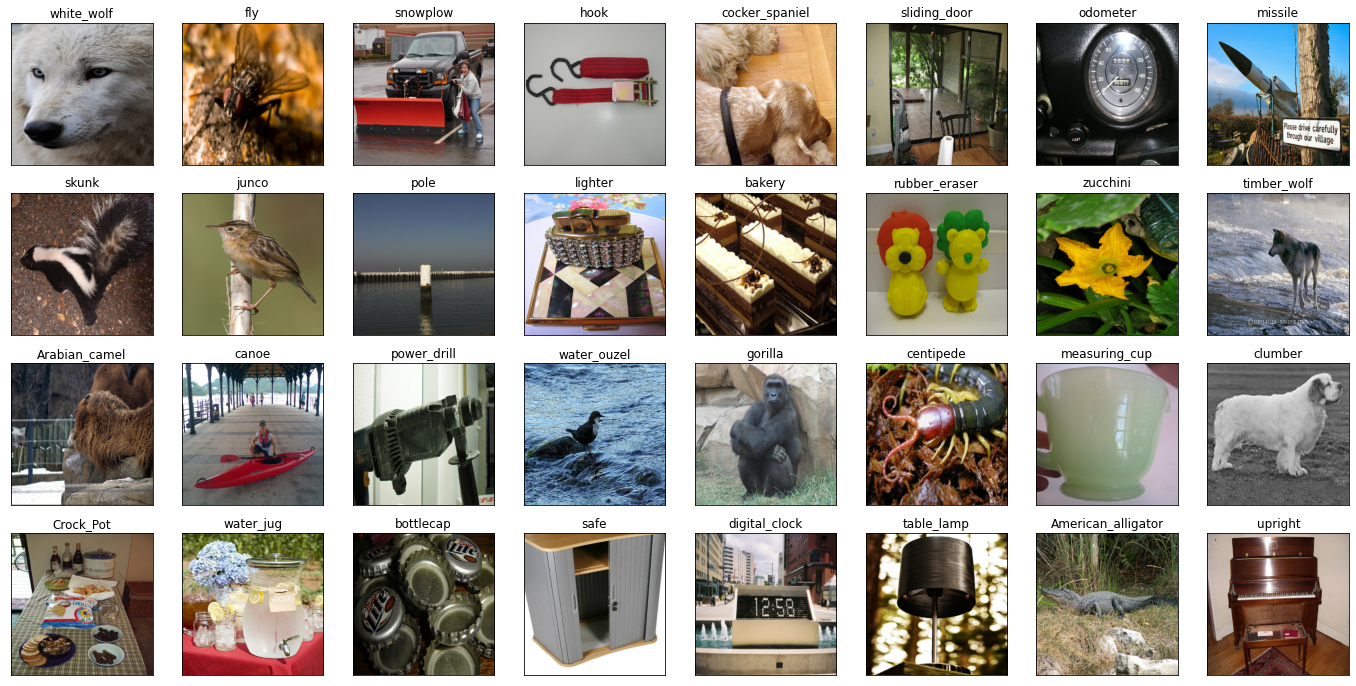

In [11]:
rows = 4
cols = 8
plt.figure(figsize = (3 * cols, 3 * rows))
for images, _ in dataset.map(preprocess_iv3).take(1):
    p = labels[model(images).numpy().argmax(1), 2]
    for idx, (im, l) in enumerate(zip(images, p)):
        plt.subplot(rows, cols, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow((im + 1) / 2)
        plt.title(l)
plt.show()

### Very first experiment: show GIG using official implementation, IG with simple custom implementation.

In [12]:
def grad_func(x, idx):
    x = tf.constant(x)[tf.newaxis]
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x)
        pred = pred[:, idx]
    return np.squeeze(tape.gradient(pred, x).numpy())

Note high computation time. Reducing steps can help.

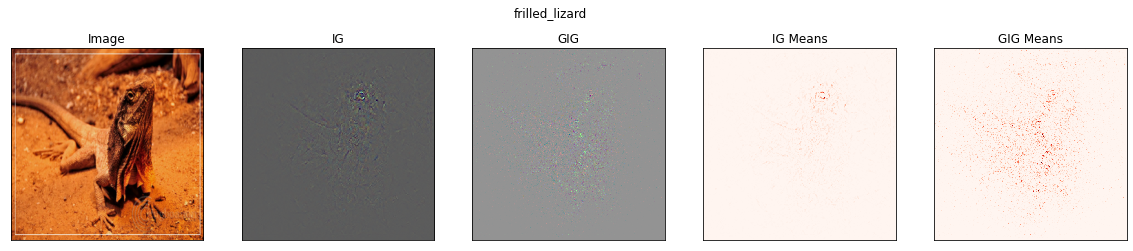

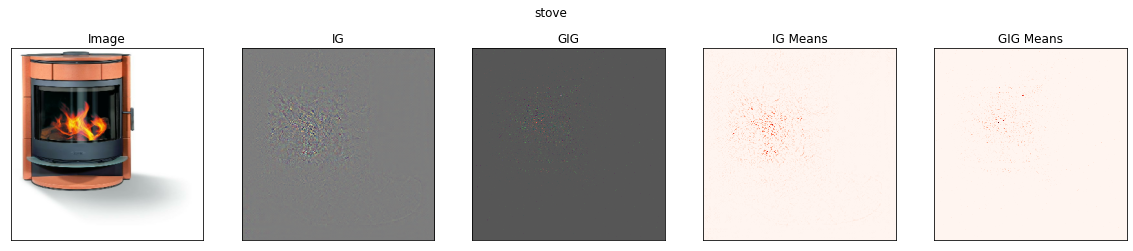

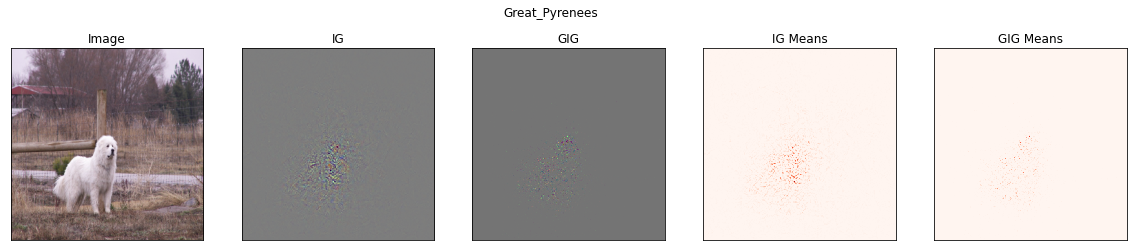

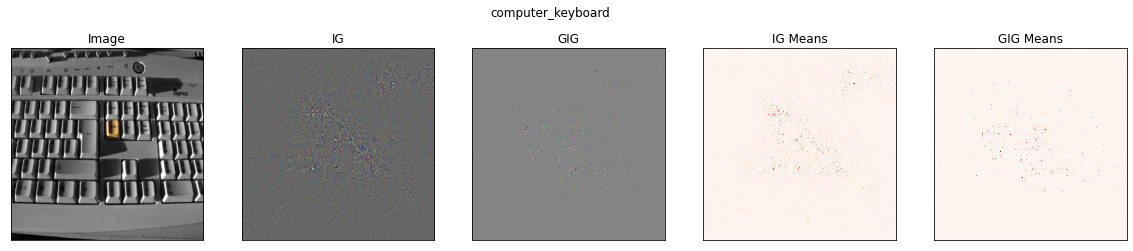

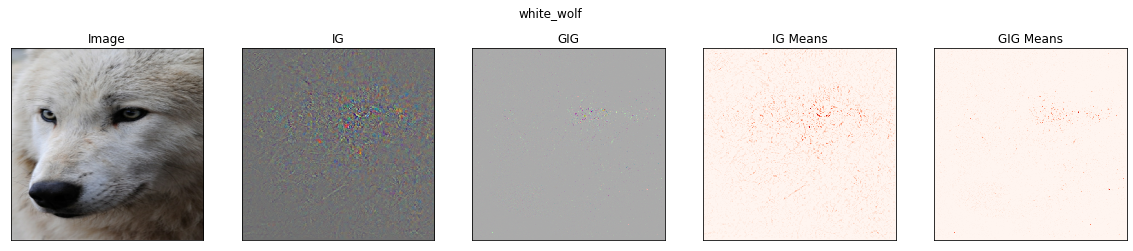

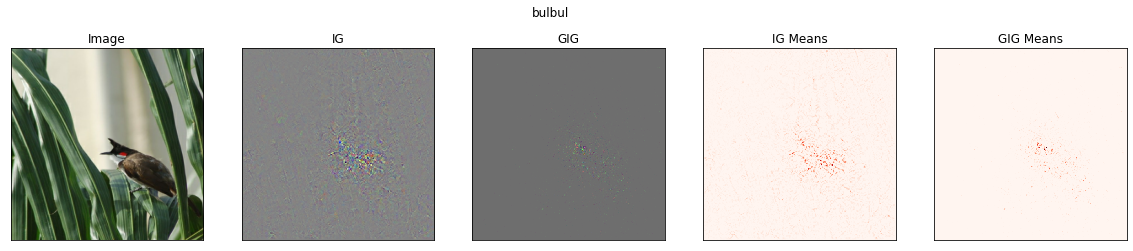

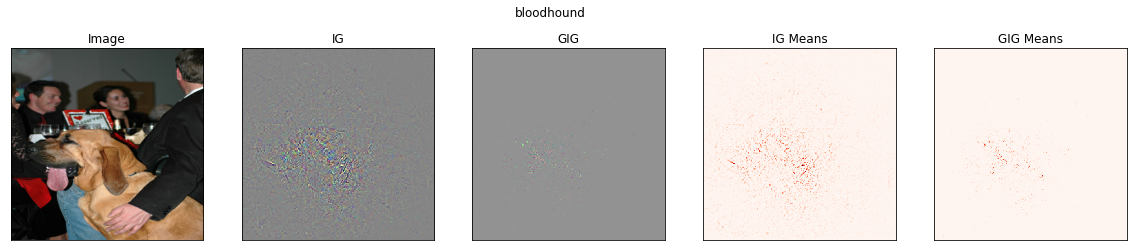

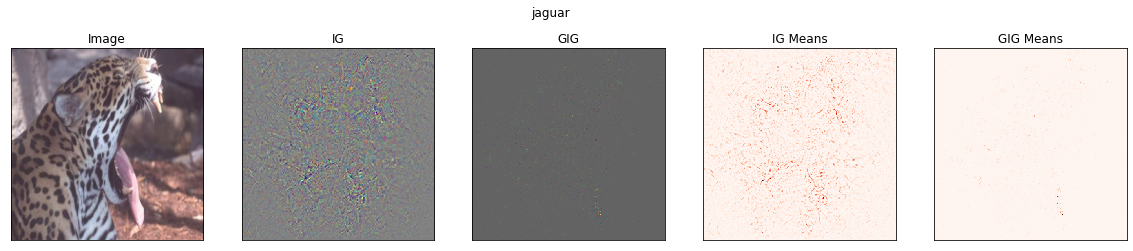

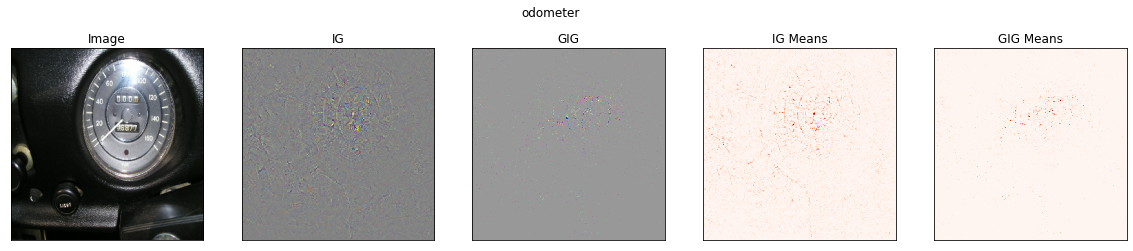

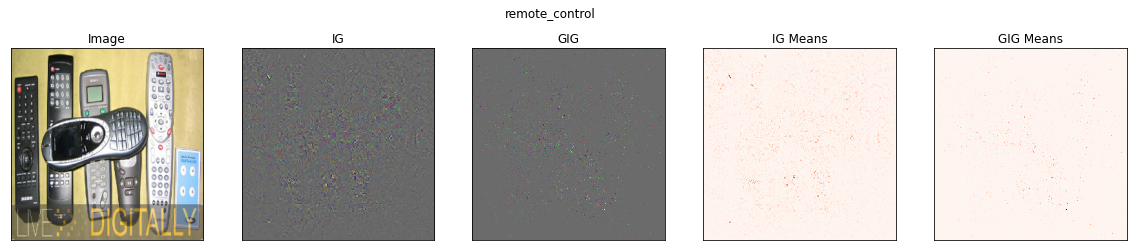

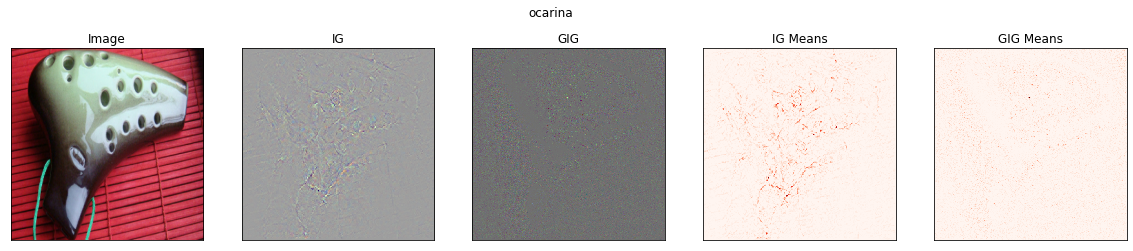

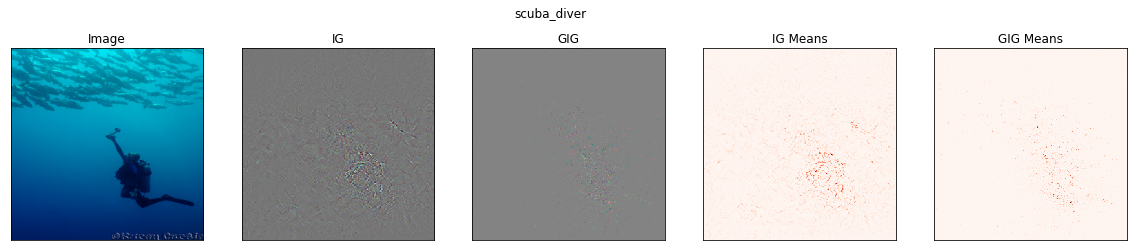

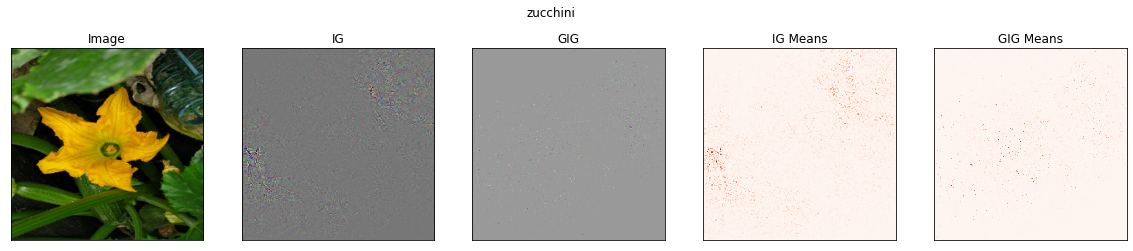

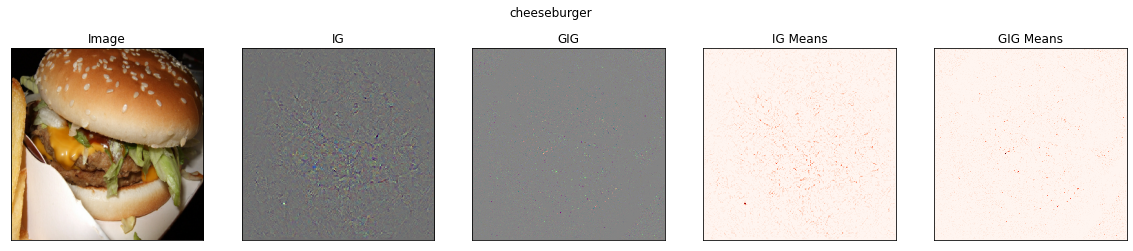

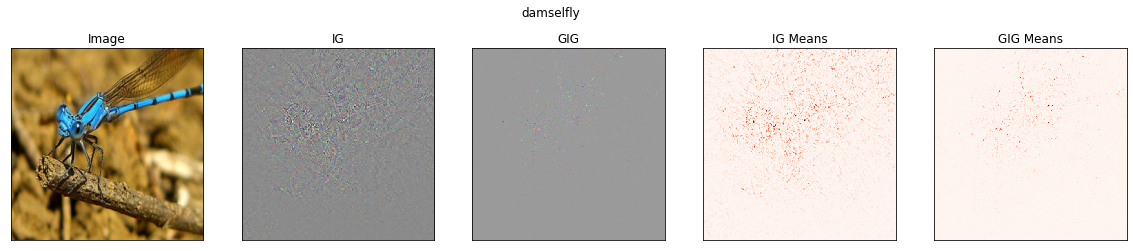

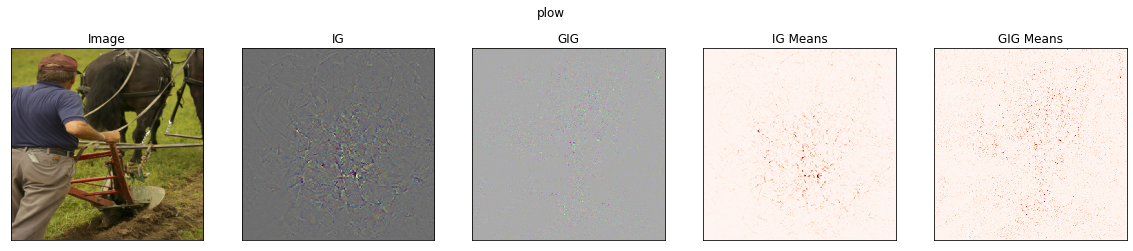

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [197]:
%%time
for images, _ in dataset.map(preprocess_iv3).take(1):
    for im in images:

        # GIG
        x_baseline = tf.zeros_like(im)
        steps = 32
        fraction = 0.1
        idx = tf.argmax(tf.reshape(model(im[tf.newaxis]), -1))

        gig = unbounded_guided_ig(
            im.numpy(),
            x_baseline.numpy(), 
            steps, 
            lambda x: grad_func(x, idx), 
            fraction
        )

        # IG
        inp = im[tf.newaxis] * tf.cast(
            tf.reshape(
                tf.linspace(0, 1, steps), 
                (steps, 1, 1, 1)), 
            im.dtype
        )
        with tf.GradientTape() as tape:
            tape.watch(inp)
            pred = model(inp)
            pred = pred[:, idx]
        grad = tape.gradient(pred, inp)
        ig = tf.reduce_sum(grad, 0).numpy()
        
        # THINGS TO PLOT
        im   = (im + 1) / 2
        
        igm  = to_unitrange( ig.mean(-1))
        gigm = to_unitrange(gig.mean(-1))
        
        ig  = to_unitrange(ig)
        gig = to_unitrange(gig) 
        
        show = [
            ('Image', lambda: plt.imshow(
                im
            )),
            ('IG',    lambda: plt.imshow(
                ig,  interpolation = 'none'
            )),
            ('GIG',   lambda: plt.imshow(
                gig, interpolation = 'none'
            )),
            ('IG Means',  lambda: plt.imshow(
                igm,  interpolation = 'none', cmap = 'Reds', vmin =  igm.mean()
            )),
            ('GIG Means', lambda: plt.imshow(
                gigm, interpolation = 'none', cmap = 'Reds', vmin = gigm.mean()
            )),
        ]
        
        plt.figure(figsize = (4 * len(show), 4))
        for jdx, (title, lam) in enumerate(show):
            plt.subplot(1, len(show), jdx + 1)
            lam()
            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.suptitle(labels[idx, 2])
        plt.show()